In [89]:
import re
import ssl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string

ssl._create_default_https_context = ssl._create_unverified_context
sns.set_theme(style="whitegrid")

rcParams['axes.grid'] = True
rcParams['savefig.transparent'] = True

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/sui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [90]:
df = pd.read_csv('patches_normalized.csv')
df

,version,champion,note,win_rate,impact,change,keyword,normalized_change
0,V10_1,Aphelios,Movement speed reduced to 325 from 330.,54.0,-1,5.0,movement speed,-0.177523
1,V10_1,Kassadin,Base movement speed reduced to 335 from 340.,50.0,-1,5.0,movement speed,-0.177523
2,V10_1,Mordekaiser,Bonus movement speed reduced to 3% at all leve...,49.0,-1,0.0,movement speed,-0.192595
3,V10_1,Sett,Active: Sett gains 30% bonus movement speed wi...,49.0,0,28.5,movement speed,-0.106684
4,V10_10,Miss Fortune,Maximum bonus movement speed reduced to 50 / 6...,46.0,-1,10.0,movement speed,-0.162451
...,...,...,...,...,...,...,...,...
14019,V13_6,Milio,NaN,NaN,0,NaN,Unknown,NaN
14020,V14_7,Skarner,NaN,NaN,0,NaN,Unknown,NaN
14021,V6_14,Yasuo,Bug Fix: Fixed a bug where Steel Tempest wasn'...,0.0,0,NaN,critical chance,NaN
14022,V6_2,Jhin,"Instead, Jhin gains attack damage from any att...",25.0,0,NaN,critical chance,NaN


In [91]:
# 1. Text Cleaning
def clean_text(text):
    if not isinstance(text, str):
        return ''
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lower case
    text = text.lower()
    return text

df['cleaned_note'] = df['note'].apply(clean_text)
df['cleaned_note'].head()

0                     movement speed reduced to  from 
1                base movement speed reduced to  from 
2    bonus movement speed reduced to  at all levels...
3    active sett gains  bonus movement speed within...
4    maximum bonus movement speed reduced to       ...
Name: cleaned_note, dtype: object

In [92]:
df['tokenized_note'] = df['cleaned_note'].apply(word_tokenize)
df['tokenized_note'].head()

0                 [movement, speed, reduced, to, from]
1           [base, movement, speed, reduced, to, from]
2    [bonus, movement, speed, reduced, to, at, all,...
3    [active, sett, gains, bonus, movement, speed, ...
4    [maximum, bonus, movement, speed, reduced, to,...
Name: tokenized_note, dtype: object

In [93]:
stop_words = set(stopwords.words('english'))
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stop_words]
df['no_stopwords'] = df['tokenized_note'].apply(remove_stop_words)
df['no_stopwords'].head()

0                           [movement, speed, reduced]
1                     [base, movement, speed, reduced]
2    [bonus, movement, speed, reduced, levels, base...
3    [active, sett, gains, bonus, movement, speed, ...
4           [maximum, bonus, movement, speed, reduced]
Name: no_stopwords, dtype: object

In [94]:
lemmentizer = WordNetLemmatizer()
df['lemmatized'] = df['no_stopwords'].apply(lambda x: [lemmentizer.lemmatize(word) for word in x])
df['lemmatized'].head()

In [ ]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['lemmatized'].apply(lambda x: ' '.join(x)))
tfidf_matrix = tfidf_matrix.toarray()
tfidf_matrix.shape

(14024, 5711)

In [ ]:
# 2. Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

curr_silhouette, optimal_k = -1, 0
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)
    silhouette_avg = silhouette_score(tfidf_matrix, kmeans.labels_)
    if silhouette_avg > curr_silhouette:
        curr_silhouette = silhouette_avg
        optimal_k = n_clusters
    print(f'For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg}')

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(tfidf_matrix)
df['cluster'] = kmeans.labels_
df['cluster'].value_counts()

# 3. Visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(tfidf_matrix)
df['pca1'] = pca_matrix[:, 0]
df['pca2'] = pca_matrix[:, 1]

For n_clusters = 2, the silhouette score is 0.015459771951974328
For n_clusters = 3, the silhouette score is 0.019267499991445693
For n_clusters = 4, the silhouette score is 0.026521475153893175
For n_clusters = 5, the silhouette score is 0.034397830961713755
For n_clusters = 6, the silhouette score is 0.04099298234511253
For n_clusters = 7, the silhouette score is 0.043924397334141614
For n_clusters = 8, the silhouette score is 0.0377331990438204
For n_clusters = 9, the silhouette score is 0.04579029670271315
For n_clusters = 10, the silhouette score is 0.0505899920411724


In [ ]:
terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]  # sort features per cluster
terms, order_centroids.shape

(array(['000', '0025', '0025second', ..., 'zyra', 'zyras', 'zzrot'],
       dtype=object),
 (10, 5711))

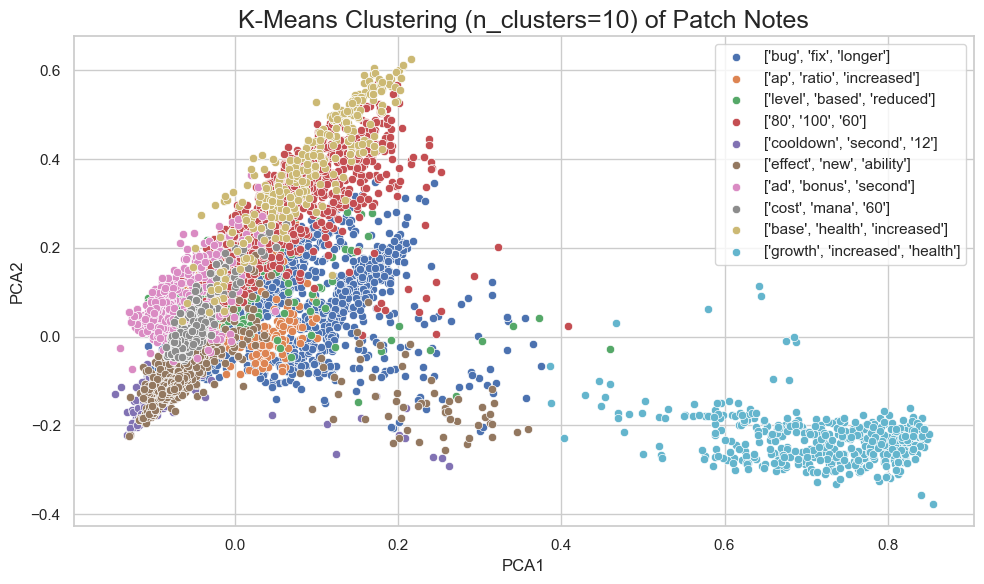

In [ ]:
plt.figure(figsize=(10, 6))
for i, cluster in enumerate(df['cluster'].unique()):
    sns.scatterplot(x=df[df['cluster'] == cluster]['pca1'], y=df[df['cluster'] == cluster]['pca2'], label=f'{[terms[ind] for ind in order_centroids[i, :3]]}')
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.title(f'K-Means Clustering (n_clusters={optimal_k}) of Patch Notes', fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig('patches_clustering.png')
plt.show()

In [ ]:
df['lemmatized_text'] = df['lemmatized'].apply(' '.join)
aggregated_df = df.groupby(['champion', 'version'])['lemmatized_text'].apply(' '.join).reset_index()
aggregated_df

,champion,version,lemmatized_text
0,Aatrox,V10_11,bug fix properly heals attacking enemy malphit...
1,Aatrox,V10_15,bug fix properly fear stop zyras enraged thorn...
2,Aatrox,V10_20,healing amplification increased 50 75 100 50 6...
3,Aatrox,V11_1,base magic resistance reduced 32 321
4,Aatrox,V11_19,cooldown reduced 20 185 17 155 14 second 26 23...
...,...,...,...
4562,Zyra,V9_17,mana cost reduced 100 rank 100 120 140 cooldow...
4563,Zyra,V9_2,base mana regeneration reduced 13 15335
4564,Zyra,V9_3,plant base damage reduced 20 100 based level 2...
4565,Zyra,V9_4,bootless walk animation added


In [ ]:
tfidf_champ = TfidfVectorizer()
tfidf_matrix_champ = tfidf_champ.fit_transform(aggregated_df['lemmatized_text'])
tfidf_matrix_champ = tfidf_matrix_champ.toarray()
tfidf_matrix_champ.shape

(4567, 5711)

In [ ]:
curr_silhouette, optimal_k = -1, 0
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(tfidf_matrix_champ)
    silhouette_avg = silhouette_score(tfidf_matrix_champ, kmeans.labels_)
    if silhouette_avg > curr_silhouette:
        curr_silhouette = silhouette_avg
        optimal_k = n_clusters
    print(f'For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg}')

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(tfidf_matrix_champ)
aggregated_df['cluster'] = kmeans.labels_
aggregated_df['cluster'].value_counts()

pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(tfidf_matrix_champ)
aggregated_df['pca1'] = pca_matrix[:, 0]
aggregated_df['pca2'] = pca_matrix[:, 1]

For n_clusters = 2, the silhouette score is 0.03343299672850513
For n_clusters = 3, the silhouette score is 0.02563401812162429
For n_clusters = 4, the silhouette score is 0.021456975256145677
For n_clusters = 5, the silhouette score is 0.029667712811742204
For n_clusters = 6, the silhouette score is 0.03328583730750665
For n_clusters = 7, the silhouette score is 0.03815056909301848
For n_clusters = 8, the silhouette score is 0.038556737577205645
For n_clusters = 9, the silhouette score is 0.039039810760406836
For n_clusters = 10, the silhouette score is 0.040121360902631666


In [ ]:
terms = tfidf_champ.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]  # sort features per cluster
terms, order_centroids.shape

(array(['000', '0025', '0025second', ..., 'zyra', 'zyras', 'zzrot'],
       dtype=object),
 (10, 5711))

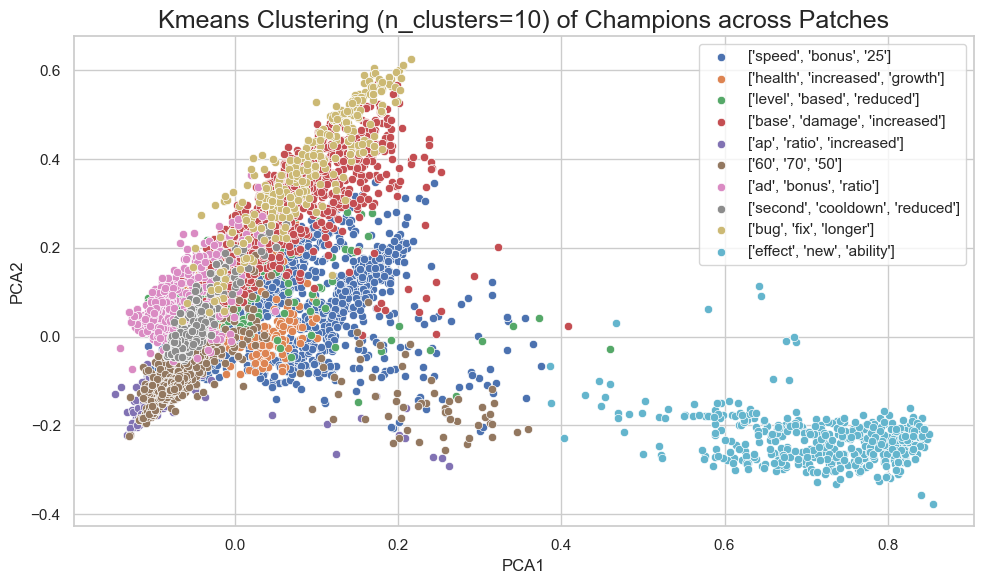

In [ ]:
plt.figure(figsize=(10, 6))
for i, cluster in enumerate(df['cluster'].unique()):
    sns.scatterplot(x=df[df['cluster'] == cluster]['pca1'], y=df[df['cluster'] == cluster]['pca2'], label=f'{[terms[ind] for ind in order_centroids[i, :3]]}')
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.title(f'Kmeans Clustering (n_clusters={optimal_k}) of Champions across Patches', fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig('champions_clustering.png')
plt.show()